!pip install lambeq
!pip install jax
!pip install qiskit



In [1]:
!pip install lambeq
!pip install jax
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 KB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 M

importing libraries and suppressing warnings

In [7]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from discopy.tensor import Tensor
from sympy import default_sort_key
from jax import jit, grad
from lambeq import BobcatParser
from lambeq import AtomicType, SpiderAnsatz
from discopy import Dim
from lambeq import AtomicType, SpiderAnsatz
from discopy import Dim
from jax import numpy as np
import numpy

np.random = numpy.random
Tensor.np = np

np.random.seed(123458)  # Fix the seed

Input Data

In [3]:
# Read data
def read_data(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    data, targets = [], []
    for ln in lines:
        t = int(ln[0])
        data.append(ln[1:].strip())
        targets.append(np.array([t, not(t)], dtype=np.float32))
    return data, np.array(targets)

train_data, train_targets = read_data('/content/mc_train_data.txt')
test_data, test_targets = read_data('/content/mc_test_data.txt')

Showing some of the data

In [4]:
train_data[:10]

['skillful_ADJ man_N prepares_TV sauce_N',
 'skillful_ADJ man_N bakes_TV dinner_N',
 'woman_N cooks_TV tasty_ADJ meal_N',
 'man_N prepares_TV meal_N',
 'skillful_ADJ woman_N debugs_TV program_N',
 'woman_N prepares_TV tasty_ADJ meal_N',
 'person_N runs_TV program_N',
 'person_N runs_TV useful_ADJ application_N',
 'woman_N prepares_TV sauce_N',
 'woman_N prepares_TV dinner_N']

Viewing Target representation

In [5]:
train_targets

DeviceArray([[1., 0.],
             [1., 0.],
             [1., 0.],
             ...,
             [0., 1.],
             [1., 0.],
             [0., 1.]], dtype=float32)

Creating and parameterising diagrams

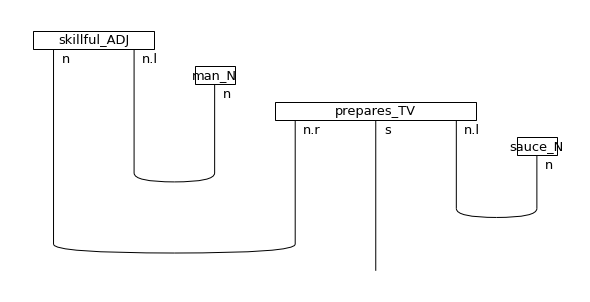

In [9]:
parser = BobcatParser(verbose='suppress')
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

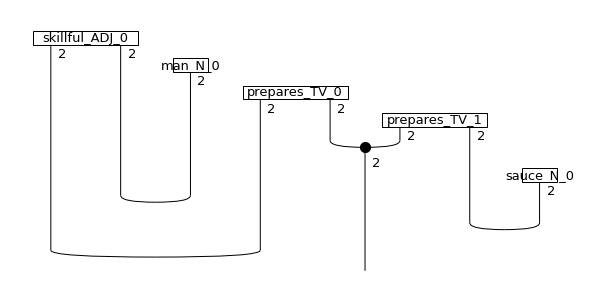

In [10]:
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

Vocab Creation

In [11]:
vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.17825215, 0.02690565])

## Training

Defining loss function

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

In [13]:
training_loss = jit(loss)
gradient = jit(grad(loss))

In [14]:
training_losses = []

epochs = 90

for i in range(epochs):

    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

Epoch 10 - loss 0.2599187195301056
Epoch 20 - loss 0.06524507701396942
Epoch 30 - loss 0.03207899630069733
Epoch 40 - loss 0.01664852909743786
Epoch 50 - loss 0.009737547487020493
Epoch 60 - loss 0.006617861799895763
Epoch 70 - loss 0.004941744729876518
Epoch 80 - loss 0.003908243030309677
Epoch 90 - loss 0.003210891503840685


Evaluation

In [15]:
np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

Accuracy on test set: 0.7
